In [319]:
# Import all the necessary modules needed to run the inference pipeline
import sys
import os

sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt
import numpy as np
import emcee
import seaborn as sns

In [332]:
experiment = "Two_wound" # either "Single_wound" or "Halfwound" or "Two_wound"
filesuffix = "_quarter"
distance = [i - 85.5 for i in [28.5, 85.5, 142.5]]
# wound edge 2 edge [i - 85 for i in [45, 65, 85, 105, 125]] # assuming an approximately 35 micron wound radius, the outer bins are placed between wound edge and next bin edge
# wound centre 2 centre [i - 85 for i in [17, 51, 85,119, 153]]
time = [10, 20] # [2.5,7.5,12.5,17.5,22.5]
time_labels = ["5-15", "15-25"]#["0-5","5-10","10-15","15-20","20-25"]
# This function reads in previously run data from walker inference pipeline, and outputs the observed bias mean and std\
# for the dataframe. The inputs are x,y which correspond to the file formats

Attempting to load ../data/BP_inference/Two_wound_CTR_revision_top_quarter_bins00.h5
Attempting to load ../data/BP_inference/Two_wound_MCR_revision_top_quarter_bins00.h5
Attempting to load ../data/BP_inference/Two_wound_CTR_revision_bottom_quarter_bins00.h5
Attempting to load ../data/BP_inference/Two_wound_MCR_revision_bottom_quarter_bins00.h5
Attempting to load ../data/BP_inference/Two_wound_CTR_revision_top_quarter_bins10.h5
Attempting to load ../data/BP_inference/Two_wound_MCR_revision_top_quarter_bins10.h5
Attempting to load ../data/BP_inference/Two_wound_CTR_revision_bottom_quarter_bins10.h5
Attempting to load ../data/BP_inference/Two_wound_MCR_revision_bottom_quarter_bins10.h5
Attempting to load ../data/BP_inference/Two_wound_CTR_revision_top_quarter_bins20.h5
Attempting to load ../data/BP_inference/Two_wound_MCR_revision_top_quarter_bins20.h5
Attempting to load ../data/BP_inference/Two_wound_CTR_revision_bottom_quarter_bins20.h5
Attempting to load ../data/BP_inference/Two_wound_

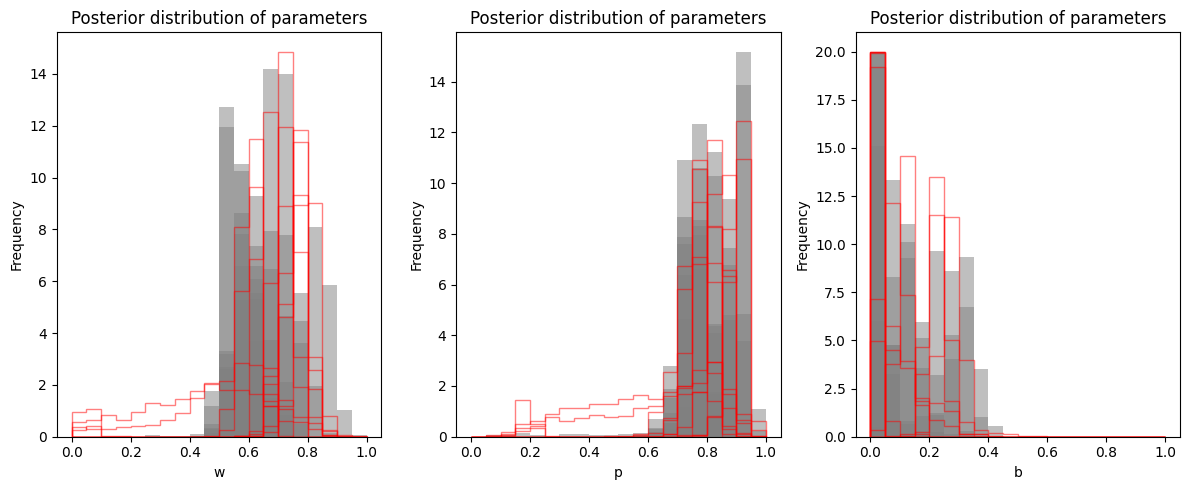

In [333]:
# calculate correlation times to estimate a burn-in and thin to use across all samples
# need to check for both CTR and MCR samples
stepSizeTimeBins = 1
nTimeBins = int(np.round(len(time_labels)/stepSizeTimeBins))
max_tau = np.ones(3)
min_tau = np.inf*np.ones(3)

# make a plot to keep trap of overall distribution of paramters
plt.figure(figsize=(12,5))
labels = ['w','p','b']

for i in range(nTimeBins):
    for j in range(len(distance)):
            for wound in ['top', 'bottom']:
                print('Attempting to load ' + '../data/BP_inference/'+experiment+'_CTR_revision_'+wound+filesuffix+'_bins{}{}.h5'.format(j,i))
                sample_data = emcee.backends.HDFBackend('../data/BP_inference/'+experiment+'_CTR_revision_'+wound+filesuffix+'_bins{}{}.h5'.format(j,i))
                tau = sample_data.get_autocorr_time(tol=0)
                max_tau = np.max((max_tau, tau), axis=0)
                min_tau = np.min((min_tau, tau), axis=0)
                # now create plot
                this_thin = int(np.min(tau))
                this_burnin = max(3000,int(2 * np.max(tau)))
                samples = sample_data.get_chain(discard=this_burnin, thin=this_thin, flat=True)
                for dim in range(3):
                    plt.subplot(1,3,dim+1)
                    plt.hist(samples[:,dim], bins=20, range=(0, 1), density= True, alpha=0.5, color='grey')
                    # sns.kdeplot(samples[:,dim], clip=[0, 1] ,color='grey')
                
                # now repeat for MCR samples
                print('Attempting to load ' + '../data/BP_inference/'+experiment+'_MCR_revision_'+wound+filesuffix+'_bins{}{}.h5'.format(j,i))
                sample_data = emcee.backends.HDFBackend('../data/BP_inference/'+experiment+'_MCR_revision_'+wound+filesuffix+'_bins{}{}.h5'.format(j,i))
                tau = sample_data.get_autocorr_time(tol=0)
                max_tau = np.max((max_tau, tau), axis=0)
                min_tau = np.min((min_tau, tau), axis=0)
                # now create plot
                this_thin = int(np.min(tau))
                this_burnin = max(3000,int(2 * np.max(tau)))
                samples = sample_data.get_chain(discard=this_burnin, thin=this_thin, flat=True)
                for dim in range(3):
                    plt.subplot(1,3,dim+1)
                    plt.hist(samples[:,dim], bins=20, range=(0, 1), density= True, alpha=0.5, color='red', histtype='step')
                    # sns.kdeplot(samples[:,dim], clip=[0, 1] ,color='red')
                    if i==0 & j==0:
                        plt.xlabel(labels[dim])
                        plt.ylabel('Frequency')
                        plt.title('Posterior distribution of parameters')
                        plt.tight_layout()

burnin = max(3000,int(2 * np.max(max_tau)))
thin = int(np.min(min_tau))
print("highest auto-correlation time: {0}".format(max_tau))
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))

plt.show()


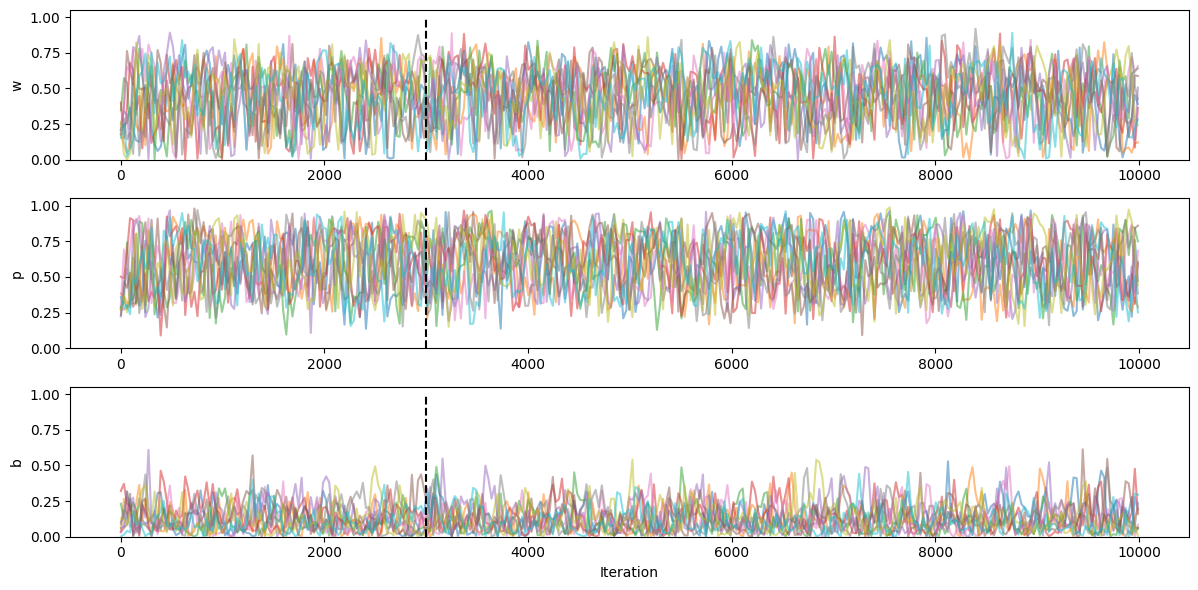

In [334]:
# plot some MCMC chains to check for a reasonable burn-in
sample_data = emcee.backends.HDFBackend('../data/BP_inference/'+experiment+'_MCR_revision_bottom'+filesuffix+'_bins00.h5')
samples = sample_data.get_chain(discard=0, thin=thin, flat=False)

labels = ['w','p','b']
ndim = samples.shape[2]
n_walkers = samples.shape[1]
n_samples = samples.shape[0]
x_iterations = np.linspace(0, n_samples*thin, n_samples)

# Trace Plots
plt.figure(figsize=(12, 6))
for dim in range(ndim):
    plt.subplot(ndim, 1, dim + 1)
    plt.plot(x_iterations, samples[:, :, dim], alpha=0.5)
    plt.plot([burnin, burnin], [0, 1], 'k--')
    plt.ylabel(labels[dim])
    plt.ylim(0, 1.05)
plt.xlabel("Iteration")
plt.tight_layout()
plt.show()

In [335]:
# define functions to extract the observed bias values from the data
def bias_param_samples_from_file(emcee_samples):
    # Removes the burn-in, thins the posterior data and flattens the walkers into a single array
    flattened_chain = emcee_samples.get_chain(discard=burnin, thin=thin, flat=True)
    w = flattened_chain[:, 0]  # The weighting parameter from the walker posterior array
    p = flattened_chain[:, 1]  # The weighting parameter from the walker posterior array
    b = flattened_chain[:, 2]  # The bias parameter from the walker posterior array
    observedBias = w * b  # The observed bias parameter from the walker posterior array
    observedPersistence = (1 - w) * p  # The observed persistence parameter from the walker posterior array
    mean_ob = np.mean(observedBias)
    std_ob = np.std(observedBias)
    mean_op = np.mean(observedPersistence)
    std_op = np.std(observedPersistence)
    return mean_ob, std_ob, mean_op, std_op

def bias_values_control(i, j, wound): 
    control_data = emcee.backends.HDFBackend('../data/BP_inference/'+experiment+'_CTR_revision_'+wound+filesuffix+'_bins{}{}.h5'.format(i,j))
    return bias_param_samples_from_file(control_data)

def bias_values_mcr(i, j, wound): 
    mcr_data = emcee.backends.HDFBackend('../data/BP_inference/'+experiment+'_MCR_revision_'+wound+filesuffix+'_bins{}{}.h5'.format(i,j))
    return bias_param_samples_from_file(mcr_data)

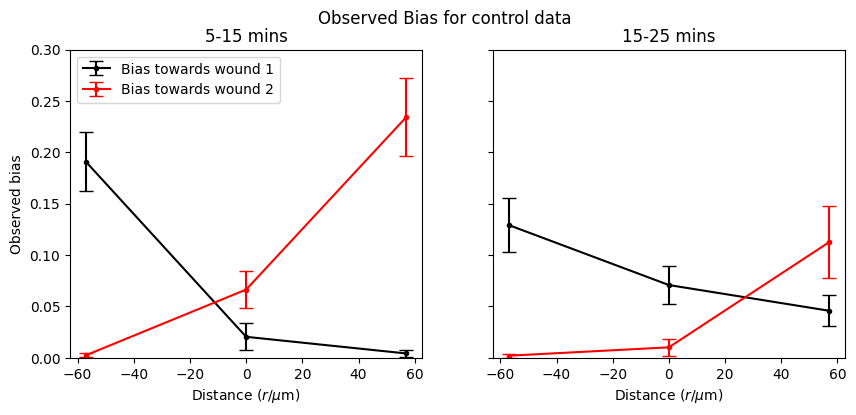

In [347]:
# plot observed bias for both conditions in one plot with a different panel for each time-point
stepSizeTimeBins = 1
nTimeBins = int(np.round(len(time_labels)/stepSizeTimeBins))
fig, ax = plt.subplots(1, nTimeBins, figsize=(10, 4), sharey=True)
fig.suptitle("Observed Bias for control data")
for i in range(nTimeBins):
    mean_ob_top = []
    std_ob_top = []
    mean_ob_bottom = []
    std_ob_bottom = []
    for j in range(len(distance)):
        ObBiasPersTop = bias_values_control(j, i*stepSizeTimeBins, 'top')
        ObBiasPersBottom = bias_values_control(j, i*stepSizeTimeBins, 'bottom')

        mean_ob_top.append(ObBiasPersTop[0])
        std_ob_top.append(ObBiasPersTop[1])
        mean_ob_bottom.append(ObBiasPersBottom[0])
        std_ob_bottom.append(ObBiasPersBottom[1])
    ax[i].errorbar(distance,mean_ob_top,yerr = std_ob_top,marker='o',markersize = 3,capsize = 5,color = 'k', label = "Bias towards wound 1")
    ax[i].errorbar([-d for d in distance],mean_ob_bottom,yerr = std_ob_bottom,marker='o',markersize = 3,capsize = 5,color = 'r', label = "Bias towards wound 2")
    ax[i].set_ylim(0,0.3)
    # ax[i].set_ylabel(f"{time_labels[i*stepSizeTimeBins]} mins", rotation=90, size='small')
    ax[i].set_title(f"{time_labels[i*stepSizeTimeBins]} mins")
    ax[i].set_xlabel("Distance ($r/\mu$m)")
# plt.xlabel("Distance ($\mu$m)")
ax[0].legend()
ax[0].set_ylabel("Observed bias")
# fig.text(0.04, 0.5, 'Observed bias', va='center', rotation='vertical', size = 'large')
plt.savefig("Figures/ObservedBiasPlots/Observed bias two wounds control_revision_data"+filesuffix+"_bins.pdf")
plt.show()

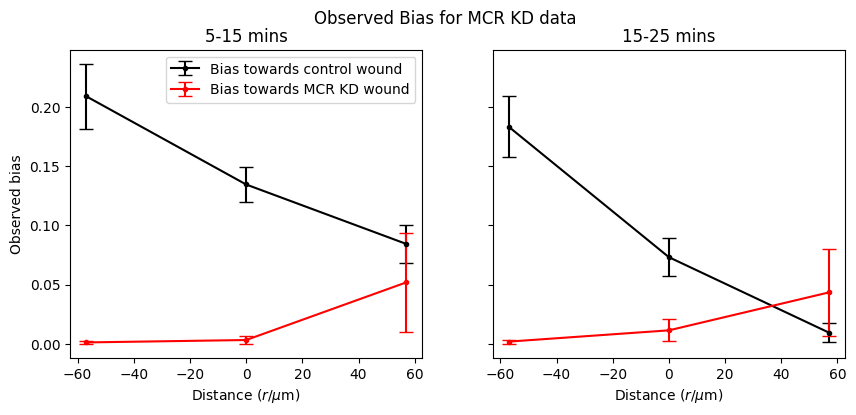

In [350]:
# plot observed bias for both conditions in one plot with a different panel for each time-point
stepSizeTimeBins = 1
nTimeBins = int(np.round(len(time_labels)/stepSizeTimeBins))
fig, ax = plt.subplots(1, nTimeBins, figsize=(10, 4), sharey=True)
fig.suptitle("Observed Bias for MCR KD data")
for i in range(nTimeBins):
    mean_ob_top = []
    std_ob_top = []
    mean_ob_bottom = []
    std_ob_bottom = []
    for j in range(len(distance)):
        ObBiasPersTop = bias_values_mcr(j, i*stepSizeTimeBins, 'top')
        ObBiasPersBottom = bias_values_mcr(j, i*stepSizeTimeBins, 'bottom')

        mean_ob_top.append(ObBiasPersTop[0])
        std_ob_top.append(ObBiasPersTop[1])
        mean_ob_bottom.append(ObBiasPersBottom[0])
        std_ob_bottom.append(ObBiasPersBottom[1])
    ax[i].errorbar(distance,mean_ob_top,yerr = std_ob_top,marker='o',markersize = 3,capsize = 5,color = 'k', label = "Bias towards control wound")
    ax[i].errorbar([-d for d in distance],mean_ob_bottom,yerr = std_ob_bottom,marker='o',markersize = 3,capsize = 5,color = 'r', label = "Bias towards MCR KD wound")
    # ax[i].set_ylabel(f"{time_labels[i*stepSizeTimeBins]} mins", rotation=90, size='small')
    ax[i].set_title(f"{time_labels[i*stepSizeTimeBins]} mins")
    ax[i].set_xlabel("Distance ($r/\mu$m)")
# plt.xlabel("Distance ($\mu$m)")
ax[0].legend()
ax[0].set_ylabel("Observed bias")

# fig.text(0.04, 0.5, 'Observed bias', va='center', rotation='vertical', size = 'large')
plt.savefig("Figures/ObservedBiasPlots/Observed bias two wounds mcr_revision_data"+filesuffix+"_bins.pdf")
plt.show()

In [351]:
def reshape_observed_params(bias_persistence_values, wound):
    reshapedBias= []
    reshapedPersistence = []
    for i in range(len(time_labels)):
        meanObservedBias = []
        stdObservedBias = []
        meanObservedPersistence = []
        stdObservedPersistence = []
        for j in range(len(distance)):
            ObBiasPers = bias_persistence_values(j, i, wound)
            meanObservedBias.append(ObBiasPers[0])
            stdObservedBias.append(ObBiasPers[1])
            meanObservedPersistence.append(ObBiasPers[2])
            stdObservedPersistence.append(ObBiasPers[3])
        reshapedBias.append([meanObservedBias,stdObservedBias])
        reshapedPersistence.append([meanObservedPersistence,stdObservedPersistence])
    return reshapedBias, reshapedPersistence

In [352]:
reshapedBias_control_top, reshapedPersistence_control_top = reshape_observed_params(bias_values_control, 'top')
reshapedBias_control_bottom, reshapedPersistence_control_bottom = reshape_observed_params(bias_values_control, 'bottom')

reshapedBias_mcr_top, reshapedPersistence_mcr_top = reshape_observed_params(bias_values_mcr, 'top')
reshapedBias_mcr_bottom, reshapedPersistence_mcr_bottom = reshape_observed_params(bias_values_mcr, 'bottom')
np.shape(reshapedBias_control_top) # dimensions are N time points, [mean, std], M distances

(2, 2, 3)

In [363]:
def plot_observed_params_all_timepoints(reshapedParams1, reshapedParams2, yAxisLabel, saveFilename):
# plot observed param values for a given condition in one plot with a different line for each time-point
    xoffset = 0#1.0
    xoffsetstart = 0# -len(time_labels)/stepSizeTimeBins/2*xoffset
    for i in range(0,len(time_labels),stepSizeTimeBins):
        plt.errorbar(np.array(distance)+xoffsetstart+i*xoffset, reshapedParams1[i][0], 
                     yerr=reshapedParams1[i][1],marker='^',markersize = 3,capsize = 5, label = f"{time_labels[i]} mins")
        plt.errorbar(np.array([-d for d in distance])+xoffsetstart+i*xoffset, reshapedParams2[i][0],
                 yerr=reshapedParams2[i][1],marker='v',linestyle='dashed',markersize = 3,capsize = 5, color=plt.gca().lines[-1].get_color())
    plt.legend()
    # plt.ylim(0,0.3)
    # plt.xlim(10,160)
    plt.xlabel("distance ($r/\mu$m)")
    plt.ylabel(yAxisLabel)
    plt.savefig(saveFilename)
    plt.show()

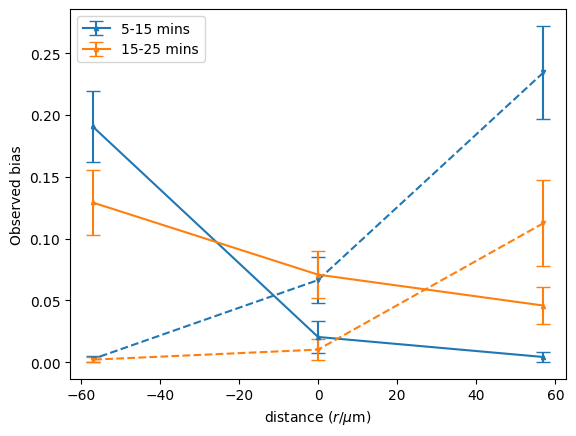

In [364]:
plot_observed_params_all_timepoints(reshapedBias_control_top, reshapedBias_control_bottom, "Observed bias", 
                                    "Figures/ObservedBiasPlots/Observed_bias_two_wound_control_revision"+filesuffix+".pdf")

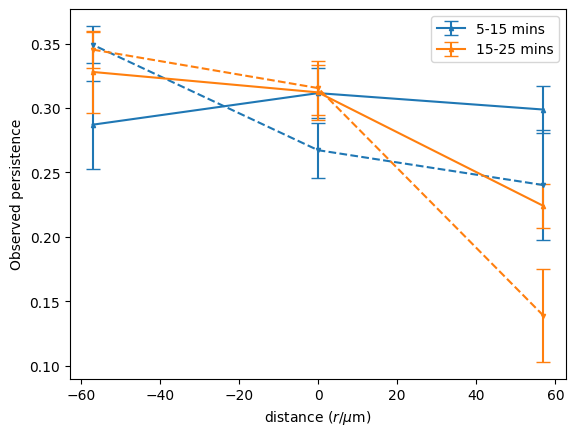

In [365]:
plot_observed_params_all_timepoints(reshapedPersistence_control_top, reshapedPersistence_control_bottom, "Observed persistence", 
                                    "Figures/ObservedBiasPlots/Observed_persistence_two_wound_control_revision"+filesuffix+".pdf")

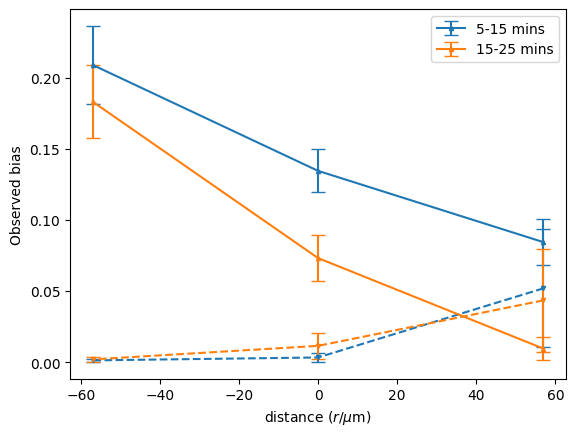

In [366]:
# plot observed bias for MCR condition in one plot with a different line for each time-point
plot_observed_params_all_timepoints(reshapedBias_mcr_top, reshapedBias_mcr_bottom, "Observed bias", 
                                    "Figures/ObservedBiasPlots/Observed_bias_two_wound_mcr_revision"+filesuffix+".pdf")

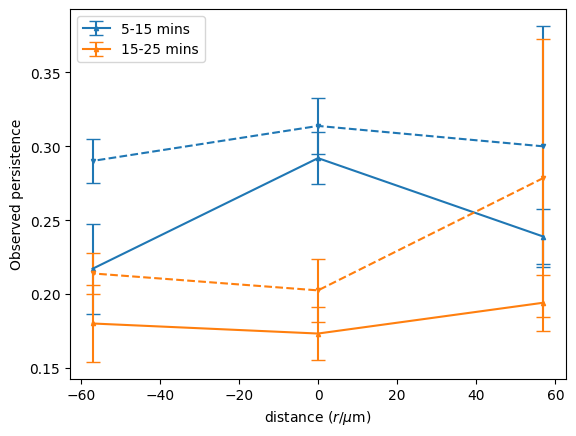

In [367]:
plot_observed_params_all_timepoints(reshapedPersistence_mcr_top, reshapedPersistence_mcr_bottom, "Observed persistence", 
                                    "Figures/ObservedBiasPlots/Observed_persistence_two_wound_mcr_revision"+filesuffix+".pdf")